<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/MLP_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [0]:
# If pytorch is not installed, uncommand and run the following line to install pytorch
#!pip install torch torchvision

In [0]:
import numpy as np

**numpy**는 다차원 배열 및 벡터/ 행렬 기본 연산
python으로 data science를 할 때 가장 기본이 되는 라이브러리 중 하나.

In [3]:
import torch
import torchvision            
import torch.nn as nn

print(torch.__version__)

1.0.1.post2


**torch**: pytorch package

**torch.nn**: 신경망 모델에 Class들을 포함

**torchvision**은 computer vision에 많이 사용되는 dataset, model, transform을 포함 (https://pytorch.org/docs/stable/torchvision/index.html)

In [0]:
from torch.utils.data import DataLoader

Data Loader: 데이터 로드를 위한 패키지 (Dataset + Sampler + Iterator)
> * Dataset is an abstract class representing a dataset 
> * Sampler provides a way to iterate over indices of dataset elements


See https://pytorch.org/docs/stable/data.html

In [0]:
from torchvision import datasets
from torchvision import transforms

**dataset**: MNIST, fashion MNIST, COCO, LSUN, CIFAR, etc.

**transforms**: algorithms for preprocessing or data augmentation

See https://pytorch.org/docs/stable/torchvision/index.html to know datasets and transforms in torchvision

# Using (deep) neural networks with python


1. Define a network model

2. Prepare data

3. Train the model

4. Evalute the model

In [0]:
%matplotlib inline

#import matplotlib

from matplotlib.pyplot import imshow, imsave

**matplotlib**: python visualization library

In [7]:
MODEL_NAME = 'MLP'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("MODEL_NAME = {}, DEVICE = {}".format(MODEL_NAME, DEVICE))

MODEL_NAME = MLP, DEVICE = cuda


GPU가 있다면 GPU를 통해 학습을 가속화하고, 없으면 CPU로 학습하기 위해 device를 정해준다.

**torch.cuda.is_avaliable()**은 GPU가 사용가능한지를 판단하는 함수

## Defining a Neural Network model using pytorch

1. Define a neural net model

> * Define a model class inheriting **nn.module**

>> nn.module is the base class of all layers/operators

>* Define **__init__** function (constructor)

>>  Create layers and operators

>* Define **forward** function (forward propagation)

>> Define how to compute the output from the input

> Example

~~~~
    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)           
                   
        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))
~~~~

> Note! You don't need to backpropagation procedure, because pytorch provides **autograd**

In [0]:
class HelloMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=200):
        super(HelloMLP, self).__init__()
        middle_size = int((input_size + hidden_size) / 2);
        self.mlp = nn.Sequential(             # a sequential container
            # 1st layer
            nn.Linear(input_size, middle_size),        # matrix multiplication (fully connected layer)            
            nn.Tanh(),                        # activation function (nn.ReLU(), nn.Tanh(), nn.Sigmoid(), etc.)
            
            # 2nd layer
            nn.Linear(middle_size, hidden_size),                # matrix multiplication (fully connected layer)
            nn.Tanh(),                        # activation function
            
            # 3rd layer
            nn.Linear(hidden_size, middle_size),
            nn.Tanh(),
            
            # 3rd layer
            nn.Linear(middle_size, input_size),
        )
    
    def forward(self, x):
        y_ = x.view(-1, 28*28)            # Reshape input tensor (N, 28, 28) --> (N, 28, 28)
        y_ = self.mlp(y_)                     # compute 
        y_ = y_.view(-1, 1, 28, 28)
        return y_

**nn.Sequential()**: a sequential container.

* Example of using Sequential

~~~~
  model = nn.Sequential(
    nn.Conv2d(1,20,5),
    nn.ReLU(),
    nn.Conv2d(20,64,5),
    nn.ReLU()
    )
~~~~
* Example of using Sequential with OrderedDict

~~~~
  model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1,20,5)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv2d(20,64,5)),
    ('relu2', nn.ReLU())
    ]))
~~~~

**nn.ModuleList()**: a list-like container class 

* Example of using ModuleList

~~~~
  class MyModule(nn.Module):
      def __init__(self):
          super(MyModule, self).__init__()
          self.linears = nn.ModuleList([nn.Linear(10, 10) for i in range(10)])
            
      def forward(self, x):
          # ModuleList can act as an iterable, or be indexed using ints
          for i, l in enumerate(self.linears):
               x = self.linears[i // 2](x) + l(x)
          return x
                 
~~~~

In [0]:
model = HelloMLP().to(DEVICE)

Moves and/or casts the parameters and buffers. (CPU or GPU)

## Loading and preprocessing data



Transform of input data

In [0]:
# mean and stdev of MNIST
mean = 0.1307
stdev = 0.3081

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),                               # image to tensor
     transforms.Normalize(mean=(mean,), std=(stdev,))  # normalize to "(x-mean)/std"
    ])

**transforms**: torchvision에서 제공하는 transform 함수들이 있는 패키지.

**ToTensor**: numpy array를 torch tensor로 변환.

**Normalize**: 정규화 함수 output[channel] = (input[channel] - mean[channel]) / std[channel]

In [0]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

**datasets**에는 여러 데이터들에 대해 다운로드하고 처리하는 클래스가 내장되어 있음. [참고](https://pytorch.org/docs/stable/torchvision/datasets.html)

root 폴더에 없을 시에 download하고, 앞서 정의한 transform에 따라 전처리 된 데이터를 return함.

In [0]:
batch_size = 64

In [0]:
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=100, shuffle=False, drop_last=False)

**DataLoader**는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.

**shuffle**: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.

**drop_last**: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

## Training neural network model


Training procedure
~~~~
for epoch in range(max_epoch):
    for input, target in dataset:    # retrieve input data and target labels
        optimizer.zero_grad()     # reset gradient
        output = model(input)     # forward propagation
        loss = loss_fn(output, target)  # get loss value
        loss.backward()           # back-propagation (compute gradient)
        optimizer.step()          # update parameters with gradient
~~~~

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
# set loss function and optimizer
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

**nn.CrossEntropyLoss**: Cross entropy를 계산하는 Loss. softmax가 내부적으로 수행된다.

**optim.Adam**: optim에는 여러 optimizer가 있고, Adam Optimizer는 대표적으로 많이 사용된다.

### Training procedure

첫번째 for문: 원하는 epoch만큼 반복

두번째 for문: training datset에서 배치 사이즈 만큼씩 모두 샘플링 될 때까지 반복.

**Line 2**: MNIST dataset은 DataLoader를 통해 image와 label을 return.

**Line 4**: 각각 Device에 올린다 (GPU or CPU)

**Line 5**: 모델에 이미지를 넣고 forward propagation 한다.

**Line 7**: 결과값 y_hat과 실제 정답 y에 대한 loss를 계산한다.

**zero_grad (Line 9)**: 모델의 gradient를 0으로 초기화한다.

**backward (Line 10)**: loss를 계산하는 것까지 연결되어있는 graph를 따라 gradient를 계산한다.

**step (Line 11)**: 계산된 gradient를 모두 parameter에 적용한다.

**eval (Line 17)**: 모델을 evaluation mode로 바꿔준다 (dropout 조정, Batch normalization 조정 등)

**torch.no_grad (Line 19)**: gradient를 계산하기 위해 추적하는 수고를 하지 않음

**torch.max (Line 24)**: max value와 indices(즉, argmax)를 return.

**train (Line 29)**: evaluation mode였던 모델을 train mode로 전환

In [0]:
# reset loss history
all_losses = []

In [18]:
max_epoch = 5        # maximum number of epochs
step = 0             # initialize step counter variable

plot_every = 200
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        x = images.to(DEVICE)       # (N, 1, 28, 28)
        
        x_hat = model(x)            # (N, 1, 28, 28)  # forward propagation
       
        loss = loss_fn(x_hat, x)  # computing loss
        total_loss += loss.item()
        
        optim.zero_grad()           # reset gradient
        loss.backward()             # back-propagation (compute gradient)
        optim.step()                # update parameters with gradient
        
        # periodically print loss
        if step % 500 == 0:
            print('Epoch({}): {}/{}, Step: {}, Loss: {}'.format(timeSince(start), epoch, max_epoch, step, loss.item()))
        
        if (step + 1) % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
        
        # periodically evalute model on test data
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():   # disable autograd
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    x_hat = model(x) # (N, 10)
                    loss = loss_fn(x_hat, x)
                    
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Test Loss: {}'.format(step, loss.item()))
            print('*'*46)
            model.train()           # turn to train mode (enable autograd)
        step += 1

Epoch(0m 0s): 0/5, Step: 0, Loss: 0.9429282546043396
******************** Test ********************
Step: 0, Test Loss: 0.932159423828125
**********************************************
Epoch(0m 5s): 0/5, Step: 500, Loss: 0.09273002296686172
Epoch(0m 10s): 1/5, Step: 1000, Loss: 0.06457987427711487
******************** Test ********************
Step: 1000, Test Loss: 0.06551981717348099
**********************************************
Epoch(0m 16s): 1/5, Step: 1500, Loss: 0.05413069948554039
Epoch(0m 21s): 2/5, Step: 2000, Loss: 0.047631680965423584
******************** Test ********************
Step: 2000, Test Loss: 0.04694858193397522
**********************************************
Epoch(0m 27s): 2/5, Step: 2500, Loss: 0.04195158928632736
Epoch(0m 31s): 3/5, Step: 3000, Loss: 0.04331032186746597
******************** Test ********************
Step: 3000, Test Loss: 0.03960748016834259
**********************************************
Epoch(0m 37s): 3/5, Step: 3500, Loss: 0.03667769208550453

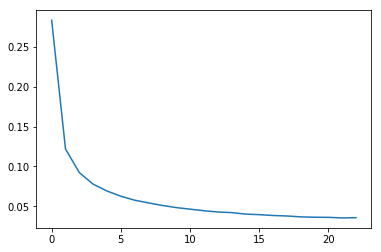

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Test and Visualize

In [20]:
# Test
model.eval()
acc = 0.
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x = images.to(DEVICE)        # (N, 1, 28, 28), (N, )
        x_hat = model(x) # (N, 10)
        loss = loss_fn(x_hat, x)
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}'.format(step, loss.item()))
print('*'*46)

******************** Test ********************
Step: 4685, Loss: 0.03541917726397514
**********************************************


In [21]:
idx = 1234 # 0 to 9999
img, _ = mnist_test[idx]
img.shape

torch.Size([1, 28, 28])

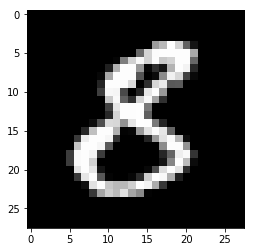

In [22]:
imshow(img[0], cmap='gray')

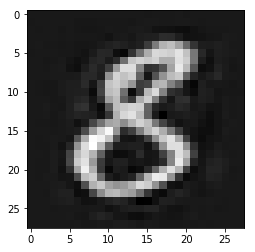

In [23]:
sample = img.to(DEVICE)
out = model(sample).cpu().detach().numpy()
out.shape
imshow(out[0,0], cmap='gray')

In [0]:
# save parameters, if necessary.
torch.save(model.state_dict(), 'model.pkl')

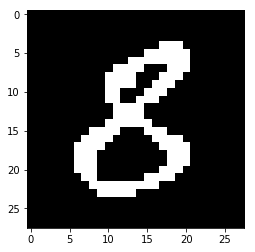

In [25]:
# binarization
threshold = (np.min(out) + np.max(out)) / 2
out_bin = (out < threshold)
imshow(out_bin[0, 0], cmap='binary')